<a href="https://colab.research.google.com/github/aksse99/ML-Basics/blob/master/SA_on_Twitter_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
nltk.download('all')
from nltk import bigrams
from nltk.tokenize import sent_tokenize, word_tokenize
import string
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
import re
import pickle

In [ ]:
train_df = pd.read_csv('train.csv')
train_df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
# find out missing values
missing_count = train_df.isnull().sum()

missing_count

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [ ]:
missing_perc = train_df.isnull().mean().round(3)*100
pd.DataFrame({'count':missing_count, 'percentage':missing_perc}).sort_values('count', ascending=False)

,count,percentage
location,2533,33.3
keyword,61,0.8
id,0,0.0
text,0,0.0
target,0,0.0


In [ ]:
# keyword and location are also categorical data
train_df['location'].value_counts()

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

<Figure size 720x360 with 0 Axes>

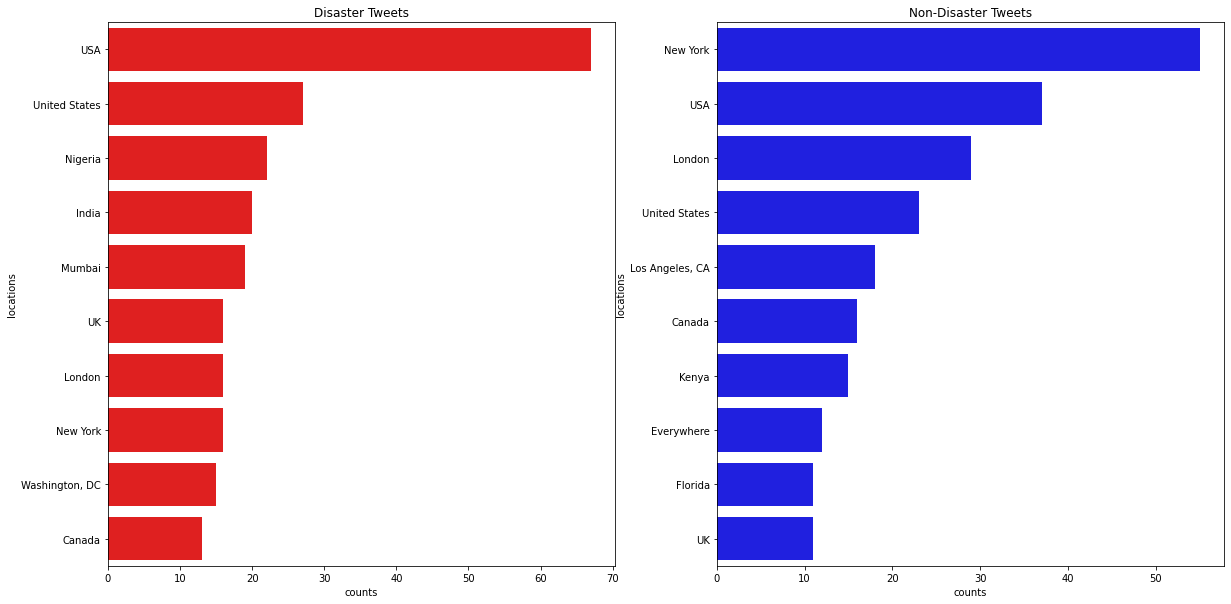

In [ ]:
# looking at the top 10 keywords from both classes
disaster = train_df[train_df['target'] == 1]['location'].value_counts()
non_disaster = train_df[train_df['target'] == 0]['location'].value_counts()

dis = disaster[:10]
non_dis = non_disaster[:10]

fig = plt.figure(figsize=(10,5))
fig, (sub1, sub2) = plt.subplots(1,2, figsize=(20,10))

sns.barplot(x=dis.values, y=dis.index, ax=sub1, color='red')
sub1.set(xlabel='counts', ylabel='locations', title='Disaster Tweets')

sns.barplot(x=non_dis.values, y=non_dis.index, ax=sub2, color='blue')
sub2.set(xlabel='counts', ylabel='locations', title='Non-Disaster Tweets')

plt.show()

In [ ]:
train_df['keyword'].value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

<Figure size 720x360 with 0 Axes>

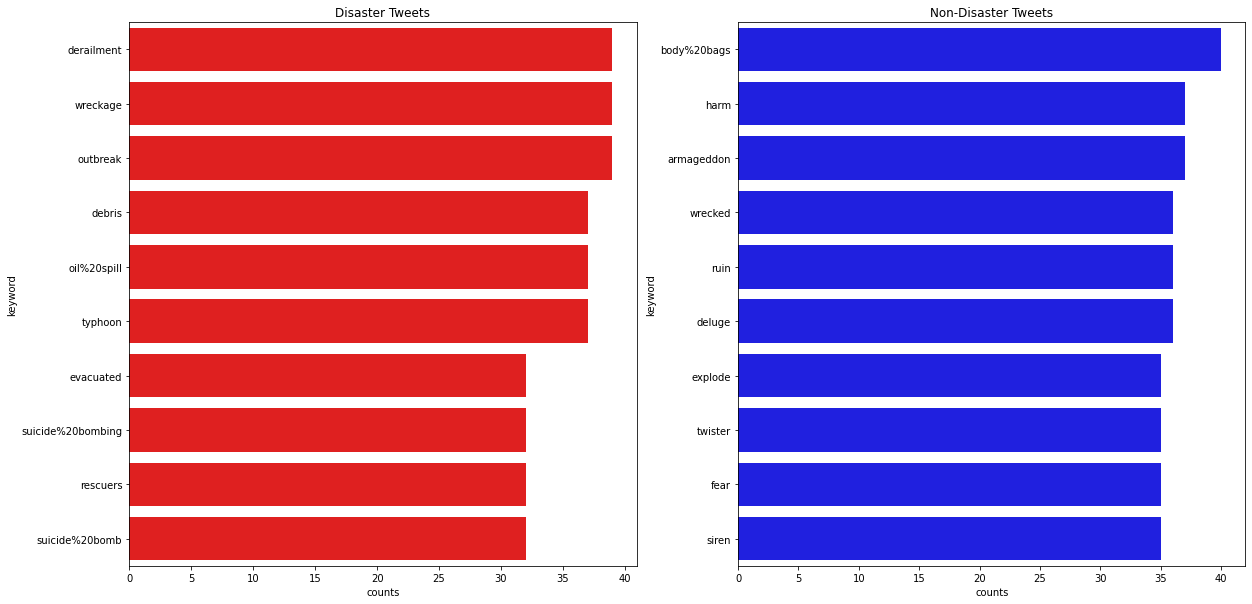

In [ ]:
# looking at the top 10 keywords from both classes
disaster = train_df[train_df['target'] == 1]['keyword'].value_counts()
non_disaster = train_df[train_df['target'] == 0]['keyword'].value_counts()

dis = disaster[:10]
non_dis = non_disaster[:10]

fig = plt.figure(figsize=(10,5))
fig, (sub1, sub2) = plt.subplots(1,2, figsize=(20,10))

sns.barplot(x=dis.values, y=dis.index, ax=sub1, color='red')
sub1.set(xlabel='counts', ylabel='keyword', title='Disaster Tweets')

sns.barplot(x=non_dis.values, y=non_dis.index, ax=sub2, color='blue')
sub2.set(xlabel='counts', ylabel='keyword', title='Non-Disaster Tweets')

plt.show()

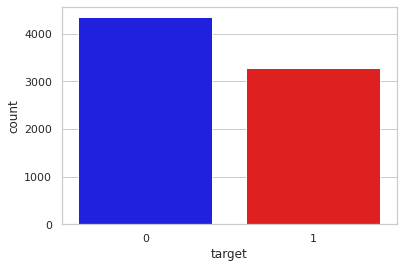

In [ ]:
# checking the target class distribution
sns.set_theme(style='whitegrid')
sns.countplot(x='target', data=train_df, palette=['blue', 'red'])

In [ ]:
# filling the NaN values in location and keyword
train_df['location'] = train_df['location'].fillna("")
train_df['keyword'] = train_df['keyword'].fillna("")

In [ ]:
train_df.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [ ]:
# pre-preprocessing functions
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [ ]:
def cleanpunc(sentence):
    cleaned = [char for char in sentence if char not in string.punctuation]
    cleaned = ''.join(cleaned)
    return cleaned

def decontracted(sentence):
    # specific
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can\'t", "can not", sentence)

    # general
    sentence = re.sub(r"n\'t", " not", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'s", " is", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'t", " not", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'m", " am", sentence)
    return sentence    

def remove_emoji(sentence):
    # taken from: https://www.kaggle.com/lovroselic/disaster-ls
    emoji_pattern = re.compile("["
                    u"\U0001F600-\U0001F64F"  # emoticons
                    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                    u"\U0001F680-\U0001F6FF"  # transport & map symbols
                    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                    u"\U00002702-\U000027B0"
                    u"\U000024C2-\U0001F251"
                    "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', sentence)

stopw = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess(sentence):
    sentence = remove_emoji(sentence)
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'html.parser').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    sentence = " ".join([stemmer.stem(word) for word in sentence.split()])
    sentence = " ".join(lemmatizer.lemmatize(word) for word in sentence.split())
    sentence = cleanpunc(sentence)
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopw)
    return sentence


In [ ]:
# combining the keyword field with text
train_df['Text'] = train_df['text']+" "+train_df['keyword']

In [ ]:
train_df.head()

,id,keyword,location,text,target,Text
0,1,,,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...
1,4,,,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada
2,5,,,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...
3,6,,,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or..."
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...


In [ ]:
train_df.Text = train_df.Text.apply(preprocess)
train_df.Text.head(10)

0         deed reason thi earthquak may allah forgiv u
1                 forest fire near la rong sask canada
2    resid ask ishelt place notifi offic evacu shel...
3          peopl receiv wildfir evacu order california
4    got sent thi photo rubi alaska smoke wildfir p...
5    rockyfir updat california hwi close direct due...
6    flood disast heavi rain caus flash flood stree...
7                               top hill see fire wood
8               emerg evacu happen build across street
9                             afraid tornado come area
Name: Text, dtype: object

In [ ]:
# storing the pre-processed text as a list
ppt = list(train_df.Text.values)
pickle.dump(ppt, open('ppt.pkl', 'wb'))

In [ ]:
len(ppt)

7613

### Vectorizing

#### 1. Using Bag-of-Words:

In [ ]:
bow = CountVectorizer(max_features=6000, ngram_range=(1,3))
bow_df = bow.fit_transform(train_df['Text']).toarray()
bow_df.shape

(7613, 6000)

In [ ]:
bow_X = bow_df
print(bow_X.shape)

(7613, 6000)


In [ ]:
pickle.dump(bow_X, open('bow_X.pkl', 'wb'))

### 2. Using Tf-Idf Vectorizer

In [ ]:
tfidf = TfidfVectorizer(max_features=6000, ngram_range=(1,3))
tfidf_X = tfidf.fit_transform(train_df['Text']).toarray()
tfidf_X.shape

(7613, 6000)

In [ ]:
print(tfidf_X.shape)

(7613, 6000)


In [ ]:
pickle.dump(tfidf_X, open('tfidf_X.pkl', 'wb'))

### 3. Using HashingVectorizer

In [ ]:
hv = HashingVectorizer(alternate_sign=False,n_features=6000, ngram_range=(1,3))
hv_X = hv.fit_transform(train_df['Text']).toarray()
hv_X.shape

(7613, 6000)

In [ ]:
pickle.dump(hv_X, open('hv_X.pkl', 'wb'))

## Modelling:

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn import metrics

In [ ]:
y = train_df['target'].values
y.shape

(7613,)

In [ ]:
# train test split for bow features
X_trainb, X_testb, y_trainb, y_testb = train_test_split(bow_X, y, test_size=0.25, random_state=42)
print(X_trainb.shape, y_trainb.shape)
print(X_testb.shape, y_testb.shape)

(5709, 6000) (5709,)
(1904, 6000) (1904,)


In [ ]:
# train test split for tfidf features
X_traint, X_testt, y_traint, y_testt = train_test_split(tfidf_X, y, test_size=0.25, random_state=42)
print(X_traint.shape, y_traint.shape)
print(X_testt.shape, y_testt.shape)

(5709, 6000) (5709,)
(1904, 6000) (1904,)


In [ ]:
# train test split for hashing vec features
X_trainh, X_testh, y_trainh, y_testh = train_test_split(hv_X, y, test_size=0.25, random_state=42)
print(X_trainh.shape, y_trainh.shape)
print(X_testh.shape, y_testh.shape)

(5709, 6000) (5709,)
(1904, 6000) (1904,)


In [ ]:
def get_roc_curve(X_train, y_train, X_test, y_test, model, title):
    
    model.fit(X_train, y_train)

    y_pred_tr = model.predict(X_train)
    y_pred_te = model.predict(X_test)
    matrix_te = confusion_matrix(y_testb,y_pred_te)
    print(matrix_te)
    fpr_tr, tpr_tr, _tr = metrics.roc_curve(y_train,  y_pred_tr)
    fpr_te, tpr_te, _te = metrics.roc_curve(y_test,  y_pred_te)
    auc_tr_bow_lr = metrics.roc_auc_score(y_train, y_pred_tr)
    auc_te_bow_lr = metrics.roc_auc_score(y_test, y_pred_te)
    plt.plot(fpr_tr,tpr_tr,label="Train, auc="+str(auc_tr_bow_lr))
    plt.plot(fpr_te,tpr_te,label="Test, auc="+str(auc_te_bow_lr))
    plt.legend(loc=4)
    plt.title(title)
    plt.show()

#### 1. Logistic Regression


In [ ]:
def train_lr(X_train, y_train, X_test, y_test):
    """
    Function to perform grid search for hyperparam tuning for LR
    """
    gsc = GridSearchCV(
        estimator = SGDClassifier(loss='log'),
        param_grid = {
            'alpha': [0.00001, 0.00005, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10, 20, 50, 100]
        }, cv=5, scoring='accuracy', n_jobs=-1)
    result = gsc.fit(X_train,y_train)
    best_params = result.best_params_
    print(f"The best params obtained are:{best_params}")
    print(f"Training accuracy: {gsc.score(X_train,y_train)}")
    print(f"Test accuracy: {gsc.score(X_test,y_test)}")
    best_lr = SGDClassifier(loss='log', alpha=best_params['alpha'])
    return best_params, best_lr

In [ ]:
# training with bow
print("Training with Bag-of-Words features:")
params, model = train_lr(X_trainb, y_trainb, X_testb, y_testb)

Training with Bag-of-Words features:
The best params obtained are:{'alpha': 0.001}
Training accuracy: 0.8703801015939744
Test accuracy: 0.8077731092436975


[[949 142]
 [226 587]]


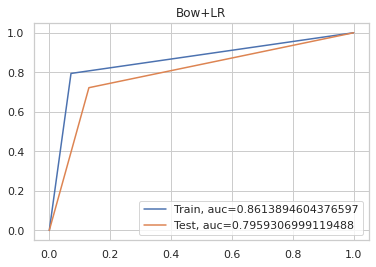

In [ ]:
get_roc_curve(X_trainb, y_trainb, X_testb, y_testb, model, "Bow+LR")

In [ ]:
# training with tfidf
print("Training with Tfidf features:")
params, model = train_lr(X_traint, y_traint, X_testt, y_testt)

Training with Tfidf features:
The best params obtained are:{'alpha': 0.0001}
Training accuracy: 0.8733578560168156
Test accuracy: 0.7988445378151261


In [ ]:
get_roc_curve(X_traint, y_traint, X_testt, y_testt, model, "tfidf+LR")

In [ ]:
# training with Hashing Vectorizer
print("Training with HashingVectorizer features:")
params, model = train_lr(X_trainh, y_trainh, X_testh, y_testh)


Training with HashingVectorizer features:
The best params obtained are:{'alpha': 0.0001}
Training accuracy: 0.8894727623051323
Test accuracy: 0.7673319327731093


In [ ]:
get_roc_curve(X_trainh, y_trainh, X_testh, y_testh, model, "Hv+LR")

#### 2. SVM

In [ ]:
def train_svm(X_train, y_train, X_test, y_test):
    """
    Function to perform grid search for hyperparam tuning for SVM
    """
    gsc = GridSearchCV(
        estimator = SGDClassifier(loss='hinge'),
        param_grid = {
            'alpha': [0.00001, 0.00005, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10, 20, 50, 100],
            'early_stopping': [True]
        }, cv=5, scoring='accuracy', n_jobs=-1)
    result = gsc.fit(X_train,y_train)
    best_params = result.best_params_
    print(f"The best params obtained are:{best_params}")
    print(f"Training accuracy: {gsc.score(X_train,y_train)}")
    print(f"Test accuracy: {gsc.score(X_test,y_test)}")
    best_svm = SGDClassifier(loss='hinge', alpha=best_params['alpha'])
    return best_params, best_svm

Results of SVM:

Training with Bag-of-Words features:


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


The best params obtained are:{'alpha': 0.001, 'early_stopping': True}
Training accuracy: 0.8901734104046243
Test accuracy: 0.7946428571428571


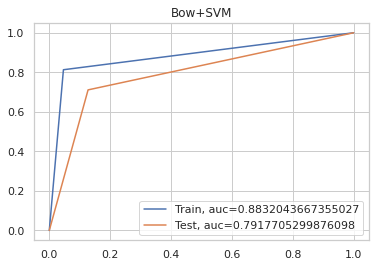

Training with Tfidf features:
The best params obtained are:{'alpha': 0.001, 'early_stopping': True}
Training accuracy: 0.8173060080574531
Test accuracy: 0.7773109243697479


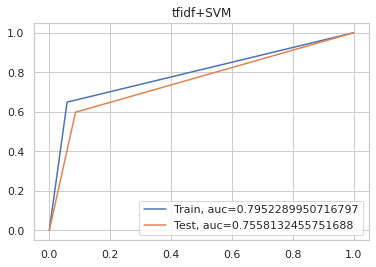

Training with HashingVectorizer features:
The best params obtained are:{'alpha': 0.0001, 'early_stopping': True}
Training accuracy: 0.8949027850761955
Test accuracy: 0.7510504201680672


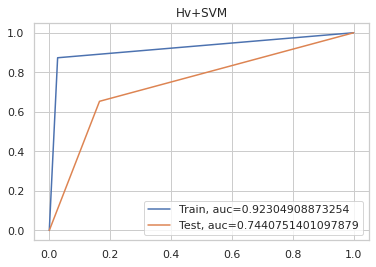

In [ ]:
# training with bow
print("Results of SVM:")
print()
print("Training with Bag-of-Words features:")
params, model = train_svm(X_trainb, y_trainb, X_testb, y_testb)
get_roc_curve(X_trainb, y_trainb, X_testb, y_testb, model, "Bow+SVM")

# training with tfidf
print("Training with Tfidf features:")
params, model = train_svm(X_traint, y_traint, X_testt, y_testt)
get_roc_curve(X_traint, y_traint, X_testt, y_testt, model, "tfidf+SVM")

# training with Hashing Vectorizer
print("Training with HashingVectorizer features:")
params, model = train_svm(X_trainh, y_trainh, X_testh, y_testh)
get_roc_curve(X_trainh, y_trainh, X_testh, y_testh, model, "Hv+SVM")

#### 3. Multinomial Naive Bayes

In [ ]:
def train_mnb(X_train, y_train, X_test, y_test):
    """
    Function to perform grid search for hyperparam tuning for multinomial naive bayes
    """
    gsc = GridSearchCV(
        estimator = MultinomialNB(),
        param_grid = {
            'alpha': np.logspace(-4, 3, num=25)
        }, cv=5, scoring='accuracy', n_jobs=-1)
    result = gsc.fit(X_train,y_train)
    best_params = result.best_params_
    print(f"The best params obtained are:{best_params}")
    print(f"Training accuracy: {gsc.score(X_train,y_train)}")
    print(f"Test accuracy: {gsc.score(X_test,y_test)}")
    best_mnb = MultinomialNB(alpha=best_params['alpha'])
    return best_params, best_mnb

In [ ]:
# training with bow
print("Results of MNB:")
print()
print("Training with Bag-of-Words features:")
params, model = train_mnb(X_trainb, y_trainb, X_testb, y_testb)
get_roc_curve(X_trainb, y_trainb, X_testb, y_testb, model, "Bow+MNB")

# training with tfidf
print("Training with Tfidf features:")
params, model = train_mnb(X_traint, y_traint, X_testt, y_testt)
get_roc_curve(X_traint, y_traint, X_testt, y_testt, model, "tfidf+MNB")

# training with Hashing Vectorizer
print("Training with HashingVectorizer features:")
params, model = train_mnb(X_trainh, y_trainh, X_testh, y_testh)
get_roc_curve(X_trainh, y_trainh, X_testh, y_testh, model, "Hv+MNB")

Results of MNB:

Training with Bag-of-Words features:
The best params obtained are:{'alpha': 1.2115276586285901}
Training accuracy: 0.8469083902609914
Test accuracy: 0.8051470588235294
Training with Tfidf features:
The best params obtained are:{'alpha': 0.31622776601683794}
Training accuracy: 0.8589945699772289
Test accuracy: 0.8067226890756303
Training with HashingVectorizer features:
The best params obtained are:{'alpha': 1.2115276586285901}
Training accuracy: 0.8458574181117534
Test accuracy: 0.7478991596638656


#### 4. Decision Tree Classifier

In [ ]:
def train_dt(X_train, y_train, X_test, y_test):
    """
    Function to perform grid search for hyperparam tuning for Decision Tree Classifier
    """
    gsc = GridSearchCV(
        estimator = DecisionTreeClassifier(),
        param_grid = {
            'criterion': ['gini', 'entropy'],
            'max_depth': [2, 4, 10, 20, 35, 50, 75, 100]
        }, cv=5, scoring='accuracy', n_jobs=-1)
    result = gsc.fit(X_train,y_train)
    best_params = result.best_params_
    print(f"The best params obtained are:{best_params}")
    print(f"Training accuracy: {gsc.score(X_train,y_train)}")
    print(f"Test accuracy: {gsc.score(X_test,y_test)}")
    best_dt = DecisionTreeClassifier(criterion=best_params['criterion'], max_depth=best_params['max_depth'])
    return best_params, best_dt

In [ ]:
# training with bow
print("Results of Decision Tree:")
print()
print("Training with Bag-of-Words features:")
params, model = train_dt(X_trainb, y_trainb, X_testb, y_testb)
get_roc_curve(X_trainb, y_trainb, X_testb, y_testb, model, "Bow + Decision Tree")

# training with tfidf
print("Training with Tfidf features:")
params, model = train_dt(X_traint, y_traint, X_testt, y_testt)
get_roc_curve(X_traint, y_traint, X_testt, y_testt, model, "tfidf+ Decision Tree")

# training with Hashing Vectorizer
print("Training with HashingVectorizer features:")
params, model = train_dt(X_trainh, y_trainh, X_testh, y_testh)
get_roc_curve(X_trainh, y_trainh, X_testh, y_testh, model, "Hv+ Decision Tree")

Results of Decision Tree:

Training with Bag-of-Words features:
The best params obtained are:{'criterion': 'gini', 'max_depth': 75}
Training accuracy: 0.8989315116482747
Test accuracy: 0.7610294117647058
Training with Tfidf features:
The best params obtained are:{'criterion': 'gini', 'max_depth': 75}
Training accuracy: 0.8973550534244176
Test accuracy: 0.7615546218487395
Training with HashingVectorizer features:
The best params obtained are:{'criterion': 'gini', 'max_depth': 75}
Training accuracy: 0.9104922052898932
Test accuracy: 0.7226890756302521


#### 5. Random Forest Classifier

In [ ]:
def train_rf(X_train, y_train, X_test, y_test):
    """
    Function to perform grid search for hyperparam tuning for Random Forest Classifier
    """
    gsc = GridSearchCV(
        estimator = RandomForestClassifier(),
        param_grid = {
            'max_depth': [4, 10, 20, 75, 100],
            'n_estimators': [10, 50, 100, 200, 300]
        }, cv=5, scoring='accuracy', n_jobs=-1)
    result = gsc.fit(X_train,y_train)
    best_params = result.best_params_
    print(f"The best params obtained are:{best_params}")
    print(f"Training accuracy: {gsc.score(X_train,y_train)}")
    print(f"Test accuracy: {gsc.score(X_test,y_test)}")
    best_rf = RandomForestClassifier(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'])
    return best_params, best_rf

In [ ]:
# training with bow
print("Results of Random Forest Classifier:")
print()
print("Training with Bag-of-Words features:")
params, model = train_rf(X_trainb, y_trainb, X_testb, y_testb)
get_roc_curve(X_trainb, y_trainb, X_testb, y_testb, model, "Bow + Random Forest")

# training with tfidf
print("Training with Tfidf features:")
params, model = train_rf(X_traint, y_traint, X_testt, y_testt)
get_roc_curve(X_traint, y_traint, X_testt, y_testt, model, "tfidf+ Random Forest")

# training with Hashing Vectorizer
print("Training with HashingVectorizer features:")
params, model = train_rf(X_trainh, y_trainh, X_testh, y_testh)
get_roc_curve(X_trainh, y_trainh, X_testh, y_testh, model, "Hv+ Random Forest")

Results of Random Forest Classifier:

Training with Bag-of-Words features:
The best params obtained are:{'max_depth': 100, 'n_estimators': 300}
Training accuracy: 0.882291119285339
Test accuracy: 0.7904411764705882
Training with Tfidf features:
The best params obtained are:{'max_depth': 100, 'n_estimators': 200}
Training accuracy: 0.8856191977579261
Test accuracy: 0.7846638655462185
Training with HashingVectorizer features:
The best params obtained are:{'max_depth': 100, 'n_estimators': 300}
Training accuracy: 0.9220528989315117
Test accuracy: 0.7584033613445378


#### 6. K-Neighbors Classifier

In [ ]:
def train_knn(X_train, y_train, X_test, y_test):
    """
    Function to perform grid search for hyperparam tuning for Random Forest Classifier
    """
    gsc = GridSearchCV(
        estimator = KNeighborsClassifier(),
        param_grid = {
            'n_neighbors': [2, 5, 10, 20, 35, 50, 100]
        }, cv=5, scoring='accuracy', n_jobs=-1)
    result = gsc.fit(X_train,y_train)
    best_params = result.best_params_
    print(f"The best params obtained are:{best_params}")
    print(f"Training accuracy: {gsc.score(X_train,y_train)}")
    print(f"Test accuracy: {gsc.score(X_test,y_test)}")
    best_knn = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'])
    return best_params, best_knn

In [ ]:
# training with bow
print("Results of K-Nearest Neighbors Classifier:")
print()
print("Training with Bag-of-Words features:")
params, model = train_knn(X_trainb, y_trainb, X_testb, y_testb)
get_roc_curve(X_trainb, y_trainb, X_testb, y_testb, model, "Bow + KNeighbors")

# training with tfidf
print("Training with Tfidf features:")
params, model = train_knn(X_traint, y_traint, X_testt, y_testt)
get_roc_curve(X_traint, y_traint, X_testt, y_testt, model, "tfidf+ KNeighbors")

# training with Hashing Vectorizer
print("Training with HashingVectorizer features:")
params, model = train_knn(X_trainh, y_trainh, X_testh, y_testh)
get_roc_curve(X_trainh, y_trainh, X_testh, y_testh, model, "Hv+ KNeighbors")

Results of K-Nearest Neighbors Classifier:

Training with Bag-of-Words features:
The best params obtained are:{'n_neighbors': 2}
Training accuracy: 0.8229111928533894
Test accuracy: 0.7153361344537815
Training with Tfidf features:
The best params obtained are:{'n_neighbors': 35}
Training accuracy: 0.7468908740585041
Test accuracy: 0.720063025210084
Training with HashingVectorizer features:
The best params obtained are:{'n_neighbors': 5}
Training accuracy: 0.8015414258188824
Test accuracy: 0.7426470588235294


In [ ]:
# making a submission with HV + RF
rf_model = RandomForestClassifier(n_estimators=300, max_depth=100)
rf_model.fit(hv_X, y)

RandomForestClassifier(max_depth=100, n_estimators=300)

In [ ]:
test_df = pd.read_csv('test.csv')
test_df.head(10)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?
8,27,NaN,NaN,What a nice hat?
9,29,NaN,NaN,Fuck off!


In [ ]:
# filling the NaN values in location and keyword
test_df['location'] = test_df['location'].fillna("")
test_df['keyword'] = test_df['keyword'].fillna("")

In [ ]:
test_df['Text'] = test_df['text']+" "+test_df['keyword']
test_df.head()

,id,keyword,location,text,Text
0,0,,,Just happened a terrible car crash,Just happened a terrible car crash
1,2,,,"Heard about #earthquake is different cities, s...","Heard about #earthquake is different cities, s..."
2,3,,,"there is a forest fire at spot pond, geese are...","there is a forest fire at spot pond, geese are..."
3,9,,,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting. #Spokane #wildfires
4,11,,,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
test_df.Text = test_df.Text.apply(preprocess)
print(test_df.Text.head(10))


0                             happen terribl car crash
1        heard earthquak differ citi stay safe everyon
2    forest fire spot pond gee flee across street c...
3                       apocalyps light spokan wildfir
4                   typhoon soudelor kill china taiwan
5                                      shake earthquak
6    would probabl still show life arsen yesterday ...
7                                                  hey
8                                             nice hat
9                                                 fuck
Name: Text, dtype: object


In [ ]:
test_hv = hv.fit_transform(test_df['Text']).toarray()
test_hv.shape

(3263, 6000)

In [ ]:
test_pred = rf_model.predict(test_hv)

In [ ]:
sample_sub = pd.read_csv('sample_submission.csv')
sample_sub.head(10)

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
5,12,0
6,21,0
7,22,0
8,27,0
9,29,0


In [ ]:
len(sample_sub.target)

3263

In [ ]:
sample_sub['target'] = test_pred
sample_sub.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [ ]:
sample_sub.tail()

,id,target
3258,10861,1
3259,10865,1
3260,10868,0
3261,10874,1
3262,10875,0


In [ ]:
sample_sub[sample_sub['target'] == 1]

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3255,10856,1
3257,10858,1
3258,10861,1
3259,10865,1


In [ ]:
sample_sub.to_csv('submission_rf_hv.csv', index=False)